# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.806360,False,-0.489130
1,-1.233618,False,-0.530538
2,-0.542871,True,3.796599
3,-0.567849,True,4.843557
4,1.236875,True,4.132975
...,...,...,...
995,-1.219869,True,5.290628
996,-2.172223,True,6.104618
997,-1.566917,False,0.283152
998,-0.713272,False,-2.010453


<AxesSubplot:xlabel='v0'>

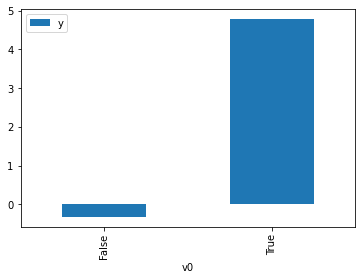

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

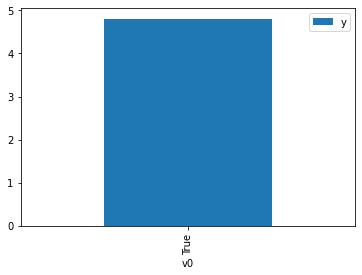

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.293048,False,-0.588240,0.899823,1.111330
1,-0.694030,False,0.826683,0.666235,1.500973
2,-0.944917,False,-1.494721,0.716505,1.395664
3,-0.239102,False,0.326657,0.565446,1.768516
4,0.131730,False,1.688801,0.478634,2.089277
...,...,...,...,...,...
995,-0.708521,False,-0.542799,0.669259,1.494191
996,0.942228,False,0.111790,0.299878,3.334685
997,-0.634890,False,-0.661387,0.653753,1.529631
998,-1.931447,False,-0.392290,0.864728,1.156433


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.681735,True,4.639871,0.336342,2.973165
1,-0.011533,True,5.096190,0.487693,2.050472
2,-0.054627,True,6.191731,0.477571,2.093928
3,-0.942950,True,4.119390,0.283871,3.522726
4,-1.498523,True,5.682775,0.190322,5.254244
...,...,...,...,...,...
995,-0.629641,True,3.705359,0.347366,2.878810
996,1.460457,True,5.447846,0.791721,1.263072
997,-0.398987,True,4.845695,0.398029,2.512378
998,1.023933,True,5.141795,0.716005,1.396639


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              4870.
Date:                Tue, 19 Jul 2022   Prob (F-statistic):                        0.00
Time:                        21:18:51   Log-Likelihood:                         -1426.3
No. Observations:                1000   AIC:                                      2857.
Df Residuals:                     998   BIC:                                      2866.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3783      0.029     13.173      0.000       0.322       0.435
x2             4.9861      0.051     98.009      0.000       4.886       5.086
==============================================================================
Omnibus:                        1.731   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.421   Jarque-Bera (JB):                1.629
Skew:                          -0.001   Prob(JB):                        0.443
Kurtosis:                       2.802   Cond. No.                         1.77
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""